# 260: Mini-Project 1
### Change in hippocampal gene expression as a function of age
#### Holly, Davis, Quirine, Monica

https://docs.google.com/document/d/1S4H_M_8vdZNvbY9RCYcJd-czcH3b_nQbM3rAh28KgiE/edit

Maybe Useful:
* [Another Gene Expression Project on R](https://mkempenaar.github.io/gene_expression_analysis/chapter-5.html)
* [Cross-Validation Guide](http://www.science.smith.edu/~jcrouser/SDS293/labs/lab7-py.html)
---




### Notes from Eran Meeting:
- transformations of age i.e. square or log of age (log >
- treat age as categorical variable - nongeneralizable to
- can import packages WOOOOOOO - this makes life much easier
- cross-validation on multiple models = Main Point of Project
- simplest - linear reg with sex, linear reg with age
- lasso regression > treat age as categorical
- with gene expression, log-transform the data
- plot distribution to see how normal it looks> for most genes, there isn't an effect of age
- multiple comparisons correction > Bonferroni or FDR correction
- need to select the genes with the highest correlation after cross-validation (basically just means to do whatever approach we choose after train-test-split, cross-val, use fit model to predict test)
- histogram of p-values > if null hypothesis is true, should just be normally distributed
Four models of complexity (regression):
- no
- Age
- Age + sex
- Age + sex + age*sex

Cross-validation of the models to compare performance. <—  most important part of the project

Or maybe not use a linear model, because gene expression is usually not linear.
- Log of age —> log function
- Square of age (?)

Non-linear model: Treat age as categorical variable —> 3 parameters if you have 4 levels (age groups)

Use packages for LASSO/Bonferroni (conservative) /Benjamini (less conservative) (or something else we talked about today during the lecture Mon 26 April)
- Use type of multiple comparison correction


Take gene selection into cross-validation (no double dipping; be careful)
OR don’t use selection and use Bonferroni

Make plot of p-values to see what that distribution looks like and if you have to be conservative or less conservative with the multiple comparison correction.

## I. Load Data

In [ ]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import PolynomialFeatures

import pickle
from tqdm import tqdm
import sys



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
sns.set_context('paper')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/Shared drives/COGS260 Note sure/Data/'
file = path + 'Hippocampus_edited.csv'

In [ ]:
df = pd.read_csv(file)
df

,Name,HiFA1aa,HiFA1b,HiFA1c,HiFA1d,HiFA1e,HiFA2a,HiFA2b,HiFA2c,HiFA2d,HiFA2e,HiFA3a,HiFA3b,HiFA3c,HiFA3d,HiFA3e,HiFA4a,HiFA4b,HiFA4c,HiFA4d,HiFA4e,HiMA1a,HiMA1b,HiMA1c,HiMA1d,HiMA1e,HiMA2a,HiMA2b,HiMA2c,HiMA2d,HiMA2e,HiMA3a,HiMA3b,HiMA3c,HiMA3d,HiMA3e,HiMA4a,HiMA4b,HiMA4c,HiMA4d,HiMA4e
0,Age,1,1,1,1,1,6,6,6,6,6,16,16,16,16,16,24,24,24,24,24,1,1,1,1,1,6,6,6,6,6,16,16,16,16,16,24,24,24,24,24
1,Sex,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M
2,Srm,-0.6169489,-0.6018166,-0.819836,-0.5790736,-0.7031439,-0.6215394,-0.4951646,-0.5772997,-0.7343021,-0.8312011,-0.7584986,-0.7569552,-0.810996,-0.6280426,-0.6975293,-0.912785,-0.6353282,-0.8478776,-0.9445233,-0.7371959,-0.9597958,-0.538711,-0.6224307,-0.5854598,-0.6364799,-0.7604223,-0.5914975,-0.7277766,-0.4218852,-0.6594927,-0.7464062,-0.8362761,-0.6332609,-0.838222,-0.6836198,-0.6235861,-0.4931112,-0.8861283,-0.894725,-0.3717937
3,1300012G16Rik,1.03429031,1.06809741,1.16210278,1.04207078,0.94178517,1.24691952,0.98256568,0.98983492,1.06060455,0.84847031,1.15162465,1.08765007,0.94505842,0.92369283,1.22713886,1.21699523,1.10858288,1.22380588,0.90677382,1.15577903,1.01608773,1.12453273,1.14504515,0.92094002,1.13796045,1.04324314,1.04473641,1.05272403,0.9555488,1.07053756,1.31394541,1.08451165,1.17125747,1.11496108,0.85952426,0.99020445,1.02833906,1.14649439,1.10604954,1.50340985
4,Amot,-0.2104829,-0.2469798,-0.2324668,-0.2949541,-0.0722088,-0.2235283,-0.1920679,0.02534639,0.01403008,-0.134437,-0.3938659,-0.0057818,-0.028824,-0.2506452,-0.2526911,-0.1315686,-0.2849481,-0.429216,-0.0440987,0.03669133,-0.1053506,-0.4150117,-0.1712775,-0.2344475,-0.4220134,-0.1454673,-0.0433342,-0.2055624,-0.077348,-0.132077,-0.1506008,-0.1790757,-0.2817751,-0.1989884,-0.0798964,-0.0542443,-0.117166,-0.1616546,-0.181012,-0.2606704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8929,Psen1,0.945491465,0.80121423,0.74547916,0.85893214,0.65857163,0.884853705,1.06539024,0.871512125,0.764891675,1.136839125,0.669181225,0.792497355,0.8562767,0.84538812,0.84891725,0.815325725,0.79261121,0.68277096,0.98460868,0.90541946,0.8430243,0.621149865,1.035930885,1.061368245,0.805244325,0.673741105,0.863191785,0.89507314,1.16064121,0.84175805,0.850527175,0.72295722,0.72243509,0.8751156,0.850979435,1.046524765,1.139360885,0.681580165,0.76977796,0.94141178
8930,E130014J05Rik,-0.2821243,0.50942947,-0.8361406,-0.9663067,-1.0487998,-0.9692492,-1.2814406,-1.2535424,-0.6563813,-0.8277175,-0.7724715,-1.0505959,-1.0799865,-1.2511659,-0.9488529,-0.8489039,-0.9485219,-1.0468273,-0.8122595,-0.8859998,-0.7459392,-1.0528987,-0.7289987,-0.2362867,-0.9789251,-1.1341609,-0.9270588,-0.924433,-0.4120873,-0.9103969,-0.7934698,-0.9362366,-1.0931396,-0.7350326,-1.2317439,-0.9450581,-0.8247524,-0.9983623,-0.7768701,-1.0075627
8931,Mpv17,0.20569825,0.289142457,0.199329243,0.30743581,0.226158743,0.334266347,0.304924393,0.207696003,0.130596753,0.179139007,0.265680513,0.288410313,0.201599493,0.393626603,0.164835253,0.12440144,0.33355488,0.271779287,0.0888858,0.274182603,0.198288677,0.440590173,0.160994573,0.122435197,0.315193817,0.22217585,0.24435112,0.26632253,0.147230693,0.308202803,0.21823647,0.22598984,0.25242365,0.322226213,0.38989385,0.17190519,0.122940377,0.262922117,0.27150683,0.28634537
8932,Cbx8,-0.7287027,-0.6337035,-0.5572978,-0.634196,-0.6205429,-0.5867247,-0.7922858,-0.5985741,-0.550721,-0.7592773,-0.5624563,-0.5189234,-0.5767894,-0.4853997,-0.4900452,-0.5641031,-0.7368498,-0.5631444,-0.71357,-0.6160912,-0.5730561,-0.5108944,-0.7725382,-0.6992297,-0.6162733,-0.4916073,-0.5735059,-0.6259158,-0.9254001,-0.4243241,-0.5053417,-0.6145861,-0.7119441,-0.7983985,-0.48076,-0.746157,-0.9657889,-0.6313636,-0.6963301,-0.782417


## II. Clean & Preprocess Data
* Delete columns with no gene names
* Rename genes that start with number
* Rename different gene isotopes
* Convert string values to numeric values
* Remove special characters in gene names


In [ ]:
#transpose the table, drop the first row (contain same information as the column name)
name_col = df.columns
df_T = df.T
new_header = df_T. iloc[0] #grab the first row for the header.
df_T.columns = new_header
df = df_T.drop(['Name'])

In [ ]:
df.head()

Name,Age,Sex,Srm,1300012G16Rik,Amot,Brwd3,Rpl10,BC003332,5730406M06Rik,A930014C21Rik,S100a6,Pde8b,Mm.10022,Jub,Prpf4b,Dhdds,AW011956,Tbl3,Madh4,NaN,A330063D19Rik,2810036K01Rik,6620401K05Rik,Xylt2,D1Ertd251e,1200013B22Rik,4432406C05Rik,Slc22a7,Ada,Comt,BC010250,Tgif,Psx1,2610008G14Rik,Rnf121,Prx,Cdv1,Rnf24,2010008E23Rik,Raf1,...,Vasp,Rnf141,Pmm2,Semcap2,4930579D07Rik,Gdf9,1110007A13Rik,Sod1,Ldh2,Blnk,Cacna1d,Lphn2,Psmb6,Tnc,1810036I24Rik,9130014L17Rik,NaN,C630015F21Rik,Apg12l,4833420G17Rik,Nedd4l,9130227L01Rik,2610528M18Rik,Gm1967,Rrm2,Nucb2,Smarcad1,1200008O12Rik,Idh1,Dhx15,Arhgap28,2010110K16Rik,BC038058,Xpnpep1,1110007C24Rik,Psen1,E130014J05Rik,Mpv17,Cbx8,DXBwg1396e
HiFA1aa,1,F,-0.6169489,1.03429031,-0.2104829,0.17459463,1.157806257,-1.3192926,1.60174138,-1.0539457,0.13676692,0.15103843,-0.5621358,1.45875149,1.54883421,0.040880385,-0.4613451,0.335699085,-0.64534765,-0.2838465,0.378253627,1.28819141,-1.7797993,-0.5277092,-0.035088975,-0.2879721,-0.0907284,-0.4497793,0.819026665,-1.1217226,-0.4922007,-0.3156098,0.24481987,-0.7448256,-0.050500543,0.29539236,-0.09892252,-1.17124695,-0.3635315,-1.1364875,...,-0.8415585,-0.273399805,-0.3249405,-0.322591,0.68716118,0.504436013,-1.3457736,-0.837339,-0.5404641,0.41015752,0.76900208,-0.5880544,-0.415238,0.193784978,-0.61424865,0.2569872,-0.7739941,-0.0618775,-0.4236535,0.64376942,-1.65750165,1.19487066,-0.7196381,-0.48060115,0.37390708,0.73321146,0.17857777,0.17297593,-1.6178396,0.143013,-0.056489623,-0.8894987,0.485198355,-0.085175065,-0.33395895,0.945491465,-0.2821243,0.20569825,-0.7287027,0.88691751
HiFA1b,1,F,-0.6018166,1.06809741,-0.2469798,-0.0692356,1.176145083,-1.0787804,1.29610856,-1.0694595,0.04233325,0.260276025,-0.6482763,1.08112675,1.81666647,0.127314015,-0.3527473,0.46757345,-0.47961015,-0.1900734,0.51947996,1.35969257,-1.9182899,-0.8797565,0.039060775,-0.1139012,0.10248472,-0.3746984,0.55106625,-0.9933498,-0.6131864,-0.4307502,0.53136028,-0.8108513,0.001653477,0.32869857,0.03185186,-1.1622314,-0.267324355,-1.103113,...,-0.83107495,-0.33737663,-0.0204326,-0.4548456,0.72655468,0.588677907,-1.4755477,-0.6280425,-0.3536724,0.43311573,0.43649535,-0.4542306,-0.5229662,0.172542868,-0.6450917,0.23482799,-0.7094138,0.21386334,-0.3317003,0.40993676,-1.4839695,1.37179144,-0.7758393,-0.22404816,0.428816847,0.84919469,0.270540185,0.246032795,-1.6779864,0.157812835,0.020642667,-0.8995481,0.379782055,0.01468972,-0.36030413,0.80121423,0.50942947,0.289142457,-0.6337035,0.98820854
HiFA1c,1,F,-0.819836,1.16210278,-0.2324668,-0.1285145,1.06805271,-1.1965053,1.14709744,-1.1943446,0.11337649,0.246703395,-0.6812358,1.18504715,1.97861886,-0.04147997,-0.2193759,0.66632473,-0.4865496,-0.2399168,0.537157603,1.45873899,-1.7732305,-0.3020545,0.147841973,-0.2452508,-0.0078704,-0.547733,0.622773785,-1.064301,-0.3173203,-0.3837471,0.27827515,-0.8890004,0.083237933,0.34917072,0.018216975,-1.1792518,-0.38329205,-1.0413041,...,-0.68680125,-0.425904385,0.08756212,-0.6195618,0.88200515,0.746030887,-1.2804431,-0.7995949,-0.4735744,0.51382502,0.23433853,-0.6087208,-0.3788999,0.47938134,-0.81434025,0.27355809,-0.9108133,0.08530352,-0.5867039,0.52564592,-1.506218,1.26298955,-0.597503,-0.22272969,0.318082067,0.60120964,0.37907567,0.368799935,-1.4568037,0.07978729,-0.01645671,-1.0164225,0.530350605,-0.1443455,-0.31748389,0.74547916,-0.8361406,0.199329243,-0.5572978,0.86451642
HiFA1d,1,F,-0.5790736,1.04207078,-0.2949541,0.08817661,1.17748836,-1.2183022,1.1728512,-1.1516902,0.16193641,0.21625212,-0.8229487,1.41033409,1.81816496,0.145219125,-0.3303476,0.058744265,-0.43179115,-0.059135,0.424885987,1.35718155,-1.6528847,-0.4389161,0.09052559,-0.2085661,0.14957871,-0.3989896,0.66651021,-0.9808846,-0.6078909,-0.4563572,0.48452084,-0.8721401,0.013268023,0.36980777,0.021136815,-1.41779725,-0.275359745,-1.1247279,...,-0.6978425,-0.33368244,0.06069785,-0.7373834,0.83492692,0.76415998,-1.4218737,-0.5715068,-0.2735539,0.39542754,0.352109135,-0.4382868,-0.2466023,0.254445305,-0.583102795,0.16777149,-0.7430769,0.17962674,-0.47

In [ ]:
#drop all columns with nan in its title, check if there's any null value in row or in column
#and the result shows that we've already get rid of all null value
df = df.loc[:, df.columns.notnull()]
col_name_nan = df.columns.isna().sum()
df_rows_nan = df.isnull().any(axis = 0).sum()
df_col_nan = df.isnull().any(axis = 1).sum()
col_name_nan,df_rows_nan,df_col_nan

(0, 0, 0)

In [ ]:
#the shape of the current df
df.shape

(40, 8683)

In [ ]:

#Just taking a look at the df
df.describe()

Name,Age,Sex,Srm,1300012G16Rik,Amot,Brwd3,Rpl10,BC003332,5730406M06Rik,A930014C21Rik,S100a6,Pde8b,Mm.10022,Jub,Prpf4b,Dhdds,AW011956,Tbl3,Madh4,A330063D19Rik,2810036K01Rik,6620401K05Rik,Xylt2,D1Ertd251e,1200013B22Rik,4432406C05Rik,Slc22a7,Ada,Comt,BC010250,Tgif,Psx1,2610008G14Rik,Rnf121,Prx,Cdv1,Rnf24,2010008E23Rik,Raf1,Acp6,...,Nr1h2,Vasp,Rnf141,Pmm2,Semcap2,4930579D07Rik,Gdf9,1110007A13Rik,Sod1,Ldh2,Blnk,Cacna1d,Lphn2,Psmb6,Tnc,1810036I24Rik,9130014L17Rik,C630015F21Rik,Apg12l,4833420G17Rik,Nedd4l,9130227L01Rik,2610528M18Rik,Gm1967,Rrm2,Nucb2,Smarcad1,1200008O12Rik,Idh1,Dhx15,Arhgap28,2010110K16Rik,BC038058,Xpnpep1,1110007C24Rik,Psen1,E130014J05Rik,Mpv17,Cbx8,DXBwg1396e
count,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40
unique,4,2,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40
top,6,M,-0.538711,1.15577903,-0.2324668,0.08338457,1.212464033,-0.9252245,1.30673319,-1.1051038,0.24860093,0.11290067,-0.509112,1.40310175,1.5461705,0.088061345,-0.3588442,0.335699085,-0.426947,0.32837191,1.28790338,-1.9055458,-0.6982011,0.082917385,-0.1470914,-0.00606,-0.2933794,0.981169355,-1.08397,-0.7825399,-0.3140125,0.60605547,-0.9892963,-0.16759918,-0.0985645,-0.03132341,-1.005821,-0.200535355,-0.9897916,-0.6309308,...,0.48404255,-0.74298465,-0.28292662,-0.3209558,-0.4548456,0.83492692,0.658149027,-1.4755477,-0.6794858,-0.5155282,0.4868555,0.298395625,-0.430854,-0.4332202,0.341531965,-0.575947985,0.21966149,0.0641846,-0.4002229,0.51513627,-1.23110705,1.38585552,-0.730334,-0.349916,0.34736952,0.63260883,0.487380405,0.289898825,-1.4644032,0.202139475,-0.018972437,-0.8894987,0.4661836,0.041566515,-0.41064985,0.84891725,-0.8277175,0.20569825,-0.9657889,0.88238759
freq,10,20,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
df = df.apply(pd.to_numeric, errors='ignore')
df.sample(5)

Name,Age,Sex,Srm,1300012G16Rik,Amot,Brwd3,Rpl10,BC003332,5730406M06Rik,A930014C21Rik,S100a6,Pde8b,Mm.10022,Jub,Prpf4b,Dhdds,AW011956,Tbl3,Madh4,A330063D19Rik,2810036K01Rik,6620401K05Rik,Xylt2,D1Ertd251e,1200013B22Rik,4432406C05Rik,Slc22a7,Ada,Comt,BC010250,Tgif,Psx1,2610008G14Rik,Rnf121,Prx,Cdv1,Rnf24,2010008E23Rik,Raf1,Acp6,...,Nr1h2,Vasp,Rnf141,Pmm2,Semcap2,4930579D07Rik,Gdf9,1110007A13Rik,Sod1,Ldh2,Blnk,Cacna1d,Lphn2,Psmb6,Tnc,1810036I24Rik,9130014L17Rik,C630015F21Rik,Apg12l,4833420G17Rik,Nedd4l,9130227L01Rik,2610528M18Rik,Gm1967,Rrm2,Nucb2,Smarcad1,1200008O12Rik,Idh1,Dhx15,Arhgap28,2010110K16Rik,BC038058,Xpnpep1,1110007C24Rik,Psen1,E130014J05Rik,Mpv17,Cbx8,DXBwg1396e
HiFA1e,1,F,-0.703144,0.941785,-0.072209,-0.045727,1.365819,-0.972884,1.069757,-1.276486,0.210576,0.224991,-0.798706,1.206397,1.524824,0.114327,-0.434925,0.162407,-0.462129,0.501637,1.376511,-1.695014,-0.455622,0.136246,-0.081557,0.148775,-0.411853,0.679801,-0.854321,-0.693017,-0.418211,0.508559,-1.054879,-0.012001,0.322080,-0.078337,-1.205498,-0.406594,-1.152195,-0.095548,...,0.083760,-0.896311,-0.206734,0.059909,-0.653357,0.700801,0.658149,-1.359685,-0.592596,-0.215538,0.019056,0.420233,-0.323770,-0.232060,0.310486,-0.724515,0.234271,0.222525,-0.506480,0.528072,-1.552722,1.000168,-0.727667,-0.308954,0.341993,0.643086,0.381867,0.314261,-1.464192,0.191279,0.007932,-1.058385,0.359387,0.041567,-0.357179,0.658572,-1.048800,0.226159,-0.620543,1.061054
HiFA4d,24,F,-0.944523,0.906774,-0.044099,0.025669,1.084634,-1.052903,1.568213,-1.562640,0.177809,0.252771,-0.537393,1.288221,1.549486,-0.010016,-0.432079,0.438518,-0.601592,0.409364,1.321078,-1.848851,-0.538302,0.175805,-0.263991,-0.071125,-0.581375,0.934199,-1.006584,-0.384069,-0.441559,0.404509,-1.110622,-0.038429,0.270556,-0.126531,-0.948394,-0.444764,-1.059591,-0.562242,...,0.459572,-0.853728,-0.174065,-0.320956,-0.334973,0.447697,0.352714,-1.147969,-0.821030,-0.609890,0.342128,0.444050,-0.514788,-0.309771,0.188931,-0.830328,0.499396,-0.141825,-0.174608,0.581791,-1.535538,1.390332,-0.806531,-0.319491,0.313068,0.554944,0.006659,0.229472,-2.071773,-0.113240,0.058180,-1.141308,0.513711,-0.265233,-0.282532,0.984609,-0.812260,0.088886,-0.713570,0.854501
HiFA3b,16,F,-0.756955,1.087650,-0.005782,-0.218061,1.333819,-1.077429,1.057476,-1.212676,0.389471,0.225180,-0.574823,1.373553,1.325136,0.051882,-0.496053,0.027122,-0.491585,0.428694,1.465366,-1.722661,-0.481023,0.128864,0.030073,0.001261,-0.330288,0.715649,-0.833156,-0.670007,-0.430787,0.526281,-1.095256,0.009533,0.352798,-0.026438,-1.103370,-0.554583,-0.979250,-0.010358,...,0.676748,-0.747918,-0.169657,0.030962,-0.681594,0.665083,0.759458,-1.254161,-0.548928,-0.302774,0.577540,0.376076,-0.323113,-0.289519,0.289290,-0.850177,0.313717,0.043871,-0.297878,0.569668,-1.688512,0.722284,-0.641607,-0.298211,0.300282,0.663702,0.370349,0.377245,-1.464403,0.202139,0.011986,-1.090699,0.332613,0.043469,-0.216376,0.792497,-1.050596,0.288410,-0.518923,1.092149
HiMA4b,24,M,-0.493111,1.028339,-0.117166,0.280331,0.924522,-1.102716,1.846783,-1.440875,-0.058231,0.130259,-0.914771,1.459503,1.683245,0.091559,-0.411355,0.069287,-0.890863,0.493165,1.442534,-1.783509,-1.207080,0.204289,-0.335462,-0.461409,-0.645635,0.913723,-1.190382,-0.616279,-0.343048,0.342304,-0.835351,0.116351,0.218918,-0.146534,-1.135468,-0.350514,-0.969639,-0.382070,...,0.221346,-0.926493,-0.306402,-0.368077,-0.191705,0.900466,0.498846,-1.412425,-0.913152,-0.719087,0.308592,0.595558,-0.797589,-0.353546,-0.823782,-0.660348,0.231411,0.122057,-0.367054,0.515808,-1.231107,1.381428,-0.778654,-0.492984,0.330585,0.669095,0.092964,0.196680,-1.808379,-0.095453,0.040087,-0.953143,0.494812,-0.184633,-0.241606,1.139361,-0.824752,0.122940,-0.965789,0.755852
HiMA1d,1,M,-0.585460,0.920940,-0.234448,0.497698,0.883434,-1.041116,1.873698,-1.170947,0.157222,0.139454,-0.479209,1.594441,1.133848,0.007924,-0.306213,0.156286,-0.822506,0.278792,1.300603,-2.083149,-0.589408,-0.023918,-0.266642,-0.444420,-0.548025,0.954699,-0.935415,-0.334751,-0.2

In [ ]:

#some column names starts with numerical value, so we added a "X" letter to every gene column name
# df.columns = 'X' + df.columns
df = df.add_prefix("X")
df = df.rename(columns = {'XAge': 'Age','XSex':'Sex'})
df.columns

Index(['Age', 'Sex', 'XSrm', 'X1300012G16Rik', 'XAmot', 'XBrwd3', 'XRpl10',
       'XBC003332', 'X5730406M06Rik', 'XA930014C21Rik',
       ...
       'XArhgap28', 'X2010110K16Rik', 'XBC038058', 'XXpnpep1',
       'X1110007C24Rik', 'XPsen1', 'XE130014J05Rik', 'XMpv17', 'XCbx8',
       'XDXBwg1396e'],
      dtype='object', name='Name', length=8683)

In [ ]:
# using ReGex to remove all the special characters and spaces
new_cols = []
for i in list(df.columns):
    new_col = re.sub(r"[^a-zA-Z0-9]","",i)
    new_cols.append(new_col)
new_cols
df.columns = new_cols

In [ ]:
#As you can see, some columns have the same name, and they represents different different isoforms,
#so we also need to rename them
df[['Age','XRpl10']].head()

,Age,XRpl10,XRpl10
HiFA1aa,1,1.157806,-0.012879
HiFA1b,1,1.176145,0.083558
HiFA1c,1,1.068053,-0.092393
HiFA1d,1,1.177488,0.008417
HiFA1e,1,1.365819,0.000999


In [ ]:
# see which names have multiple isoforms
df.columns.value_counts()

XEef1a1           4
XKrt28            4
X5830484A20Rik    3
X1500031M22Rik    3
XMap3k12          3
                 ..
XRdbp             1
X2610024N24Rik    1
XEps8l2           1
X1600027N09Rik    1
XNanog            1
Length: 8402, dtype: int64

In [ ]:
print('So we have', sum(df.columns[2:].value_counts() != 1), 'columns with isoforms')

cols=pd.Series(df.columns)

for dup in cols[cols.duplicated()].unique():
    cols[cols[cols == dup].index.values.tolist()] = [dup + 'isoform' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

# rename the columns with the cols list
df.columns = cols
df.columns[2:].value_counts()

So we have 266 columns with isoforms


XEral1            1
XInhba            1
X1110004F10Rik    1
X4930444A02Rik    1
XMrpl52           1
                 ..
XPlac1            1
XVps4bisoform1    1
XLOC665033        1
XAutl1            1
XNanog            1
Length: 8681, dtype: int64

In [ ]:


assert sum(df.columns[2:].value_counts() != 1) == 0

In [ ]:
# change Sex columns into numerals
# F = 0, M = 1
new_sex = []
for sex in df['Sex'].values:
    if sex == 'F':
        dummy = 0
    elif sex == 'M':
        dummy = 1
    new_sex.append(dummy)
df['Sex'] = new_sex
df.sample(3)

,Age,Sex,XSrm,X1300012G16Rik,XAmot,XBrwd3,XRpl10,XBC003332,X5730406M06Rik,XA930014C21Rik,XS100a6,XPde8b,XMm10022,XJub,XPrpf4b,XDhdds,XAW011956,XTbl3,XMadh4,XA330063D19Rik,X2810036K01Rik,X6620401K05Rik,XXylt2,XD1Ertd251e,X1200013B22Rik,X4432406C05Rik,XSlc22a7,XAda,XComt,XBC010250,XTgif,XPsx1,X2610008G14Rik,XRnf121,XPrx,XCdv1,XRnf24,X2010008E23Rik,XRaf1,XAcp6,...,XNr1h2,XVasp,XRnf141,XPmm2,XSemcap2,X4930579D07Rik,XGdf9,X1110007A13Rik,XSod1,XLdh2,XBlnk,XCacna1d,XLphn2,XPsmb6,XTnc,X1810036I24Rik,X9130014L17Rik,XC630015F21Rik,XApg12l,X4833420G17Rik,XNedd4l,X9130227L01Rik,X2610528M18Rik,XGm1967,XRrm2,XNucb2,XSmarcad1,X1200008O12Rik,XIdh1,XDhx15,XArhgap28,X2010110K16Rik,XBC038058,XXpnpep1,X1110007C24Rik,XPsen1,XE130014J05Rik,XMpv17,XCbx8,XDXBwg1396e
HiFA1c,1,0,-0.819836,1.162103,-0.232467,-0.128515,1.068053,-1.196505,1.147097,-1.194345,0.113376,0.246703,-0.681236,1.185047,1.978619,-0.041480,-0.219376,0.666325,-0.486550,0.537158,1.458739,-1.773230,-0.302055,0.147842,-0.245251,-0.007870,-0.547733,0.622774,-1.064301,-0.317320,-0.383747,0.278275,-0.889000,0.083238,0.349171,0.018217,-1.179252,-0.383292,-1.041304,-0.124035,...,0.743885,-0.686801,-0.425904,0.087562,-0.619562,0.882005,0.746031,-1.280443,-0.799595,-0.473574,0.513825,0.234339,-0.608721,-0.378900,0.479381,-0.814340,0.273558,0.085304,-0.586704,0.525646,-1.506218,1.262990,-0.597503,-0.222730,0.318082,0.601210,0.379076,0.368800,-1.456804,0.079787,-0.016457,-1.016423,0.530351,-0.144345,-0.317484,0.745479,-0.836141,0.199329,-0.557298,0.864516
HiFA3d,16,0,-0.628043,0.923693,-0.250645,0.100270,1.467847,-1.233959,1.045089,-0.995133,0.603533,0.112901,-0.509112,1.489274,1.120579,0.169203,-0.527153,0.129524,-0.421044,0.357789,1.073929,-2.102999,-0.337438,-0.056935,-0.026333,0.114616,-0.610259,0.729088,-0.961189,-0.769245,-0.367330,0.542120,-0.952516,-0.163179,0.228771,0.029835,-1.402591,-0.400436,-1.198337,-0.046306,...,0.327856,-0.742985,-0.161243,0.108755,-0.824565,0.230340,0.400141,-1.373201,-0.463594,-0.078362,0.258771,0.484890,-0.224817,-0.252869,0.042790,-0.777968,0.193217,0.191812,-0.491592,0.574000,-1.769099,0.750972,-0.865315,-0.273931,0.446105,0.925397,0.423010,0.091567,-1.463156,0.326163,0.215508,-1.058523,0.322381,0.057153,-0.269148,0.845388,-1.251166,0.393627,-0.485400,1.218893
HiMA3e,16,1,-0.683620,0.859524,-0.079896,0.065966,1.307791,-1.158164,1.118601,-1.207534,0.334151,0.254772,-0.552086,1.181468,1.295698,0.046094,-0.530950,0.183571,-0.454530,0.391687,1.287903,-1.948962,-0.547127,0.027854,-0.053982,0.101843,-0.250710,0.677536,-0.832267,-0.871572,-0.345450,0.559965,-0.886450,-0.095013,0.294606,-0.054756,-1.165634,-0.388200,-1.040376,-0.092757,...,0.481984,-0.845384,-0.190955,-0.086888,-0.725854,0.422531,0.581011,-1.300982,-0.396727,-0.182664,0.393759,0.356771,-0.321475,-0.215142,0.113148,-0.750018,0.365403,-0.174942,-0.342005,0.595401,-1.718886,0.533326,-0.730334,-0.321465,0.432596,0.968856,0.372427,0.351728,-1.407356,0.322704,0.017997,-1.181659,0.365995,0.087863,-0.303364,0.850979,-1.231744,0.389894,-0.480760,1.269578


## III. Exploratory Data Analaysis & Visualization

Text(0.5, 0, 'Age (Months)')

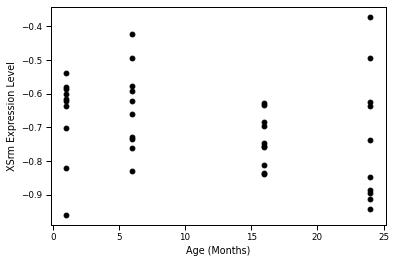

In [ ]:

# Exploratory data analysis - "simple linear regression"

# Just trying this out with one gene Srm

# plot Srm gene expression over age in black circles.
plt.plot(df['Age'], df['XSrm'], 'ko') # looks weird?
plt.ylabel('XSrm Expression Level')
plt.xlabel('Age (Months)')

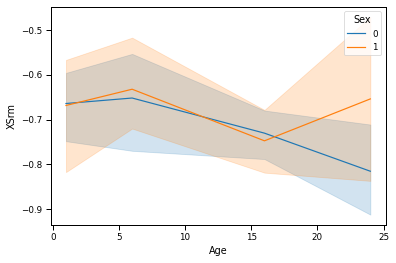

In [ ]:
#just taking a look at how does gene SRM expression change across age in male/female
genes = df.columns[2:]
sns.lineplot(x = 'Age',y = 'XSrm',hue = 'Sex',data = df);

## IV. Try Models - OLS, Multiple Regression

In [ ]:
# Simple regression for 1 gene
mdl = sm.ols(formula = 'XSrm ~ Age', data=df).fit()
print(mdl.summary())

                            OLS Regression Results                            
Dep. Variable:                   XSrm   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     2.768
Date:                Fri, 04 Jun 2021   Prob (F-statistic):              0.104
Time:                        16:32:32   Log-Likelihood:                 23.698
No. Observations:                  40   AIC:                            -43.40
Df Residuals:                      38   BIC:                            -40.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6478      0.036    -18.020      0.0

In [ ]:
#calculate the correlation coefficient between every gene expression level and Age
#get r-squared values as well
gene_name = list(df.columns[2:])
models = []
params = []
r_sqs = {}

for i in gene_name:
    # print(i)
    # sys.stdout.flush()
    s = '{}'.format(i) + '~ Age'
    mdl = sm.ols( '{}'.format(s), data=df).fit()
    r_sqs[i] = mdl.rsquared
    params.append(mdl.params)

In [ ]:
#create a dict object for every gene name and gene coeff
gene_coeff = [row[1] for row in params]
gene_inter = [row[0] for row in params]

gene_coeff_dict = dict(zip(gene_name,gene_coeff))

In [ ]:
#create a new df for the correlation coefficients
# corr_df = pd.DataFrame(gene_coeff_dict)
corr_df = pd.DataFrame(gene_coeff, gene_name)
# corr_df = corr_df.drop(['Intercept'],axis = 0).T.reset_index()

#sort the new df by the absolute values of correlation coefficient
corr_df['abs_corr_values'] = abs(corr_df)
corr_df.sort_values(by = ['abs_corr_values'],ascending = False)

sorted_corr_df  = corr_df.sort_values(by = ['abs_corr_values'],ascending = False)

sorted_corr_df = sorted_corr_df.reset_index()
sorted_corr_df.columns = ['gene', 'corr_vals', 'abs_corr_vals']
sorted_corr_df.sample(2)

,gene,corr_vals,abs_corr_vals
7334,X2310067E08Rik,0.000413,0.000413
6886,XScnn1b,-0.000536,0.000536


Text(0, 0.5, 'R-Squared')

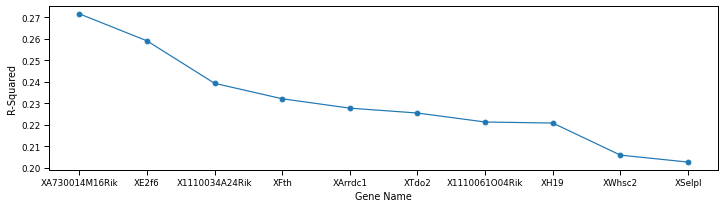

In [ ]:

#new df of r-squared values
r_sq_df = pd.DataFrame(r_sqs.values(), r_sqs.keys())
sorted_r_sq_df = r_sq_df.sort_values(by = 0, ascending = False)


plt.figure(figsize = (12,3))
plt.plot(sorted_r_sq_df[:10], '-o')
plt.xlabel("Gene Name")
plt.ylabel('R-Squared')

In [ ]:
sorted_r_sq_df

,0
XA730014M16Rik,2.716237e-01
XE2f6,2.590629e-01
X1110034A24Rik,2.392804e-01
XFth,2.320964e-01
XArrdc1,2.277296e-01
...,...
XPrp19,7.896075e-09
X6330404A12Rik,5.795170e-09
XTcn2,5.037726e-09
XB4galt3,3.451040e-09


Text(0, 0.5, 'Abs Corr Coeff')

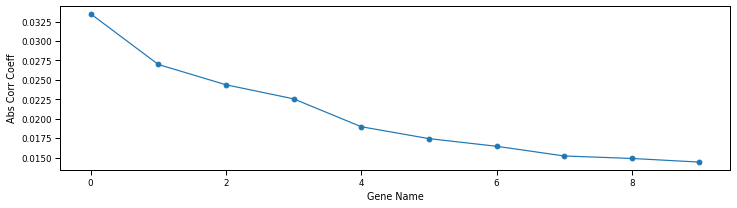

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(sorted_corr_df['abs_corr_vals'][:10], '-o')
plt.xlabel("Gene Name")
plt.ylabel('Abs Corr Coeff')

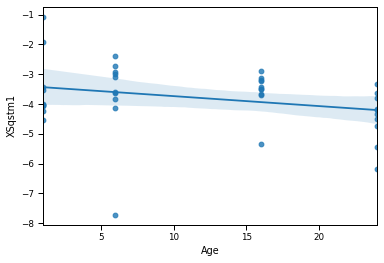

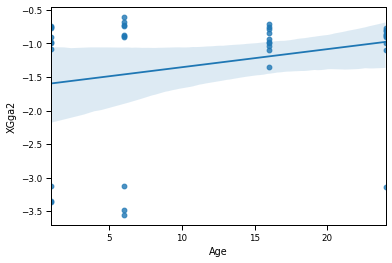

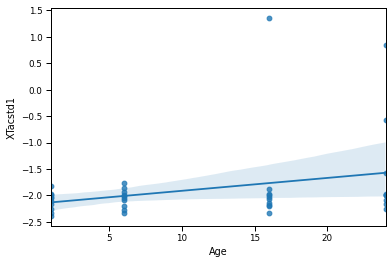

In [ ]:
#plot the first 3 genes
for gene,_, abs_corr in sorted_corr_df.values[:3]:
    sns.regplot(x="Age", y=gene,data=df)
    print()
    plt.show()

In [ ]:
# Filter genes of interest; the ones with the greatest change in expression

In [ ]:
# Hypothesis testing (GO-analysis)
# to check whether the genes with the most expression have also been identified
# as being important for memory

In [ ]:
# Repeat steps above but for striatum dataset

In [ ]:
.75*40


30.0

## V. LOO Cross-Validation + Model Comparison
* Model 1: X_age = df['Age']
* Model 2: X_sex = df['Sex']
* Model 3: X_both = df.iloc[:, 0:2]
* Model 4:
```
    # interaction = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
    # X_inter = interaction.fit_transform(x)
    # model = LinearRegression().fit(X_inter, y)
```




In [ ]:
raise STOPCODE

NameError: ignored

Data Visualization
* dots per age and regression line
* Sex differences in gene expression
* 4 models on X, MSE on Y
* train and test errors on plot

In [ ]:
cross_val_score?

In [ ]:
# https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/

#Degree = 1
#split raw DF into IVs (age, sex) and DVs (gene expression)
X_IVs = df.iloc[:, 0:2]
y_genes = df.iloc[:, 2:]

gene_names = list(y_genes.columns)
n_genes = len(gene_names)
feature_list = ['logAge','Age*Sex','Age+Sex', 'Age','Sex']

results = {}
all_models = {}
for feature in feature_list:
    print()
    print(feature,'\n')

    for idx, gene in enumerate(tqdm(gene_names, position=0)):

        # X changes depending on the model we want
        if feature in ['Age', 'Sex']:
            X = df[feature].values.reshape(-1,1)
        elif feature == 'logAge':
            X = np.log(df['Age'].values).reshape(-1,1)
        elif feature == 'Age+Sex':
            X = df[['Age', 'Sex']].values.reshape(-1,2)
        elif feature == 'Age*Sex':
            X = df[['Age', 'Sex']].values.reshape(-1,2)
            interaction = PolynomialFeatures(degree = 1, interaction_only = True, include_bias = False)
            X = interaction.fit_transform(X)

        y = df[gene].values.reshape(-1,1)
        model = LinearRegression().fit(X, y)

        # LOOCV object
        loo = LeaveOneOut()
        # crossvalidation = KFold(n_splits=40, random_state=None, shuffle=False) #this is the same as LOOCV

        #evaluate model
        scores = cross_val_score(model, X, y, scoring="r2", cv=loo, n_jobs=-1)

        #store results
        results['{}~{}'.format(gene, feature)] = scores
        all_models['{}~{}'.format(gene, feature)] = model
    sys.stdout.flush()


  0%|          | 0/8681 [00:00<?, ?it/s]


logAge 



  1%|          | 96/8681 [00:08<12:31, 11.43it/s]


KeyboardInterrupt: ignored

In [ ]:
results

{'X0610009D07Rik~logAge': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan]),
 'X0610011N22Rik~logAge': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan]),
 'X0610012A05Rik~logAge': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan]),
 'X1200013B22Rik~logAge': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [ ]:
num_models = len(results)
num_models*40

3880

In [ ]:
age_values = []
log_values = []
sex_values = []
both_values = []
inter_values = []

for key in tqdm(results):
    if 'Age*Sex' in key:
        inter_values.append(results[key])
    elif 'log' in key:
        log_values.append(results[key])
    elif 'Age+Sex' in key:
        both_values.append(results[key])
    elif 'Sex' not in key and '*' not in key and '+' not in key:
        age_values.append(results[key])
    else:
        sex_values.append(results[key])

assert len(age_values) == len(sex_values)
assert len(both_values) == len(inter_values)
assert len(sex_values) == len(inter_values)

100%|██████████| 43405/43405 [00:00<00:00, 807459.10it/s]


In [ ]:
results

{'XSrm~logAge': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan]),
 'X1300012G16Rik~logAge': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan]),
 'XAmot~logAge': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan]),
 'XBrwd3~logAge': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
      

In [ ]:
# # average across different models separately
# mean_errors = {}
# for key in results:
#     mean_errors[key] = np.mean(results[key])


In [ ]:
# age_values = []
# log_values = []
# sex_values = []
# both_values = []
# inter_values = []

# for key in tqdm(mean_errors):
#     if 'Age*Sex' in key:
#         inter_values.append(mean_errors[key])
#     elif 'log' in key:
#         log_values.append(mean_errors[key])
#     elif 'Age+Sex' in key:
#         both_values.append(mean_errors[key])
#     elif 'Sex' not in key and '*' not in key and '+' not in key:
#         age_values.append(mean_errors[key])
#     else:
#         sex_values.append(mean_errors[key])

# assert len(age_values) == len(sex_values)
# assert len(both_values) == len(inter_values)
# assert len(sex_values) == len(inter_values)

In [ ]:
model_values = [age_values, sex_values, both_values, inter_values, log_values]

model_means = []
for value_set in model_values:
    model_mean = np.mean(value_set)
    model_means.append(model_mean)
model_means

# best_model_MSE = min(np.abs(model_means))

In [ ]:
boop = pd.DataFrame(age_values, gene_names)
boop.columns = ['MSE']
boop.sort_values(by=['MSE'], ascending = False)[:10]


In [ ]:
# get linear function for each gene
top_genes = (boop.sort_values(by=['MSE'], ascending = False)[:10]).index
for gene in top_genes:
    intercept = all_models['{}~Age'.format(gene)].intercept_
    coef = all_models['{}~Age'.format(gene)].coef_
    print('{} Expression = '.format(gene), intercept , '+ {}x_age'.format(coef))

In [ ]:
for gene in top_genes:
    intercept = all_models['{}~Sex'.format(gene)].intercept_
    coef = all_models['{}~Sex'.format(gene)].coef_
    print('{} Expression = '.format(gene), intercept , '+ {}x_sex'.format(coef))

To Do:
- top genes after get best model (model with lowest mse)
- plots/figures
- writeup

In [ ]:
# model_dict = {'age': age_values, 'sex': sex_values, 'age+sex': both_values, 'age*sex':inter_values }
# df_analysis = pd.DataFrame(model_dict, columns = ['age', 'sex', 'age+sex', 'age*sex'])


In [ ]:
labels = [*np.repeat('age', n_genes), *np.repeat('sex',n_genes), *np.repeat('age+sex', n_genes), *np.repeat('age*sex',n_genes), *np.repeat('log_age',n_genes)]
values = [*age_values, *sex_values, *both_values, *inter_values, *log_values]

dict_analysis = {'model': labels, 'log_MSE': np.log(np.abs(values))}
df_analysis = pd.DataFrame(dict_analysis)

In [ ]:
df_analysis

In [ ]:
# change seaborn so that labels are bigger etc.
sns.set_context("talk")
sns.set(rc={"figure.figsize":(7, 5)})

In [ ]:
sns.violinplot(x= 'model', y='log_MSE', data=df_analysis)


In [ ]:
#change in gene expression levels for the top 5 genes.
#The y axis specifies the gene of interest, and the
#X axis specifies the years.

sns.set(font_scale = 2)

fig, axs = plt.subplots(figsize=(30,30),ncols=2, nrows = 5)
# fig.suptitle('change in gene expression level across age', fontsize=50) #

sns.lineplot(x = 'Age', y = 'XPgm2l1', data = df, ax=axs[0,0])
sns.lineplot(x = 'Age', y = 'XInadl', data = df, ax=axs[0,1]);
sns.lineplot(x = 'Age', y = 'XAtrx', data = df, ax=axs[1,0]);
sns.lineplot(x = 'Age', y = 'XOrc4l', data = df, ax=axs[1,1]);
sns.lineplot(x = 'Age', y = 'XItgb4bp', data = df, ax=axs[2,0]);
sns.lineplot(x = 'Age', y = 'XAA407526', data = df, ax=axs[2,1])
sns.lineplot(x = 'Age', y = 'XKit', data = df, ax=axs[3,0]);
sns.lineplot(x = 'Age', y = 'XTlk2', data = df, ax=axs[3,1]);
sns.lineplot(x = 'Age', y = 'XFoxp1', data = df, ax=axs[4,0]);
sns.lineplot(x = 'Age', y = 'XH19', data = df, ax=axs[4,1]);

In [ ]:
#change in gene expression levels for the top 5-10 genes.
#The y axis specifies the gene of interest, and the
#X axis specifies the years.

fig, axs = plt.subplots(figsize=(50,10),ncols=5)
fig.suptitle('change in gene expression level across age',fontsize=50)

sns.lineplot(x = 'Age', y = 'XAA407526', data = df, ax=axs[0])
sns.lineplot(x = 'Age', y = 'XKit', data = df, ax=axs[1]);
sns.lineplot(x = 'Age', y = 'XTlk2', data = df, ax=axs[2]);
sns.lineplot(x = 'Age', y = 'XFoxp1', data = df, ax=axs[3]);
sns.lineplot(x = 'Age', y = 'XH19', data = df, ax=axs[4]);


In [ ]:
# # https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/
# #split raw DF into IVs (age, sex) and DVs (gene expression)
# X_IVs = df.iloc[:, 0:2]
# y_genes = df.iloc[:, 2:]

# gene_names = list(y_genes.columns)
# n_genes = len(gene_names)
# feature_list = ['Age*Sex','Age+Sex', 'Age','Sex']

# results = {}
# all_models = {}
# for feature in feature_list:
#     print()
#     print(feature,'\n')

#     for idx, gene in enumerate(tqdm(gene_names, position=0)):

#         # X changes depending on the model we want
#         if feature in ['Age', 'Sex']:
#             X = df[feature].values.reshape(-1,1)
#         elif feature == 'Age+Sex':
#             X = df[['Age', 'Sex']].values.reshape(-1,2)
#         elif feature == 'Age*Sex':
#             X = df[['Age', 'Sex']].values.reshape(-1,2)
#             interaction = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
#             X = interaction.fit_transform(X)

#         y = df[gene].values.reshape(-1,1)
#         model = LinearRegression().fit(X, y)

#         # LOOCV object
#         loo = LeaveOneOut()
#         # crossvalidation = KFold(n_splits=40, random_state=None, shuffle=False) #this is the same as LOOCV

#         #evaluate model
#         scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=loo, n_jobs=-1)

#         #store results
#         results['{}~{}'.format(gene, feature)] = scores
#         all_models['{}~{}'.format(gene, feature)] = model
#     sys.stdout.flush()


In [ ]:
# ## Save the results so don't have to rerun
# with open('results.pickle', 'wb') as lm_results:
#     pickle.dump(results, lm_results)
# lm_results.close()

In [ ]:
# # results saved from running the code below
# pickle_off = open ("results.pickle", "rb")
# results = pickle.load(pickle_off)


In [ ]:
# # https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/

# df2 = df.sample(frac = 1)
# df_train = df2[:(.8*40)]
# df_test = df2[(:8*40):]

# #split raw DF into IVs (age, sex) and DVs (gene expression)
# X_IVs_train = df_train.iloc[:, 0:2]
# y_genes_train = df_train.iloc[:, 2:]

# X_IVs_test = df_test.iloc[:, 0:2]
# y_genes_test = df_test.iloc[:, 2:]

# gene_names = list(y_genes.columns)
# n_genes = len(gene_names)
# feature_list = ['Age*Sex','Age+Sex', 'Age','Sex']

# results = {}
# for feature in feature_list:
#     print(feature,'\n')

#     for idx, gene in enumerate(tqdm(gene_names, position=0)):

#         # LOOCV object
#         loo = LeaveOneOut()

#         #X changes depending on the model we want
#         if feature in ['Age', 'Sex']:
#             X = df_train[feature].values.reshape(-1,1)
#         elif feature == 'Age+Sex':
#             X = df_train[['Age', 'Sex']].values.reshape(-1,2)
#         elif feature == 'Age*Sex':
#             X = df_train[['Age', 'Sex']].values.reshape(-1,2)
#             interaction = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
#             X = interaction.fit_transform(X)

#         y = df_train[gene].values.reshape(-1,1)
#         model = LinearRegression().fit(X_train, y_train)
#         loo.get_n_splits(X)

#         crossvalidation = KFold(n_splits=, random_state=None, shuffle=False) #n_splits = 40 is the same as LOOCV

#         #so apparently this line is equivalent to evaluating/testing the model when using Kfold/LOOCV
#         scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=crossvalidation, n_jobs=-1)
#         # print("Folds: " + str(len(scores)) + ", MSE: " + str(np.mean(np.abs(scores))) + ", STD: " + str(np.std(scores)))


#         #lowest MSE > y_pred = predict(X_test)
#         Mse...



#         results['{}~{}'.format(gene, feature)] = scores
#     sys.stdout.flush()




In [ ]:
# # LOOVC method I stole from this website: https://www.analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r/?
# # Alternative Reference: http://www.science.smith.edu/~jcrouser/SDS293/labs/lab9-py.html

# # split into predictor values (X) and target values (y)
# X = train_df.iloc[:, 0:2]
# y_genes = df.iloc[:, 2:]

# # Independent variable --> age/sex/age*sex
# print("\nIndependent variable :")
# print(X.sample(5))

# # Dependent variable --> gene expression
# print("\nDependent variables :")
# print(y_genes.sample(5))

# # creating the leav one out function
# loo = LeaveOneOut()
# loo.get_n_splits(X)

# list_models = ['~ Age', '~ Sex', '~ Age + Sex', '~ Age * Sex']
# gene_names = list(y_genes.columns)
# n_genes = len(gene_names)

# r_sqr_overall = np.zeros((4, n_genes))# --> this is the matrix to calculate and compare the R^2 and do the model comparison

# # for index, model in enumerate(tqdm(list_models)):
# #     print(' Model with {}'.format(model), "\n")
# #     # create empty list for each model
# models = []
# params = []
# r_sqs_train = {}
# r_sqs_test = {}

# for i_idx, i in enumerate(tqdm(gene_names, position=0)): # insert model you want to test

#     # Only consider target data pertaining to the gene in this iteration
#     y = y_genes.iloc[:, i_idx]

#     # Leave one out method
#     for train_index, test_index in loo.split(X):

#     # step 1: divide training and test data
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#         assert len(X_test) == 1 #cause it's LOO


#     # step 2: train model for each gene in training set
#         #calculate the correlation coefficient between every gene expression level and Age
#         #get r-squared values as well

#         s = '{}{}'.format(i, model)
#         mdl = sm.ols( '{}'.format(s), data=train_df).fit()
#         r_sqs_train[int(test_index)] = mdl.rsquared
#         params.append(mdl.params)

#     # step 3: test model --> plus save average/sum of R2 (error)
#         #retrieve indx of model with lowest error/best performance
# #         # r_sqr_test ...


# # # Calculate average R2 (of tests) for this gene and this model
# # # Put in matrix of models and genes (4 by n_genes) (outside of loo.split forloop, but inside gene forloop)
# # r_sqr_overall[index, i] = np.mean(r_sqr_test)


# # New for loop to:
#   # Compare Average of R2 for each model (averaged over genes)
#   # Highest R2 will be the most optimal model over all genes

# # From most optimal model --> index by top genes

# # Next step --> interpret genes